In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
all_regs <- c("FC", "MSC", "TC", "OC")


dataFile <- "./load_files/AdultFetal_integration_plot_data.rds"
if (!file.exists(dataFile)){
    pdata_list <- lapply(all_regs, function(reg){
            print(sprintf("Load integrated data for region: %s", reg))
            seu <- readRDS(file = paste0("./load_files/", "AdultFetal_ExN_", reg, "_v1.slim.rds"))

            seu@meta.data$colcls <- seu@meta.data$subtype
            seu@meta.data$colcls[is.na(seu@meta.data$subtype)] <- seu@meta.data$mres[is.na(seu@meta.data$subtype)]
            seu@meta.data$colcls <- gsub("ExN deep KIF26A|ExN deep nascent|ExN up nascent", "ExN nascent", 
                                         seu@meta.data$colcls) %>%
                                    gsub("IPC EOMES NHLH1 deep|IPC EOMES NHLH1 up", "IPC EOMES NHLH1", .) %>%
                                    gsub("IPC EOMES VIM", "IPC EOMES NEUROG1", .) %>%
                                    gsub("ExN PCC NR4A3", "ExN up ACTN2", .) %>%
                                    gsub("ExN up KCNV1", "ExN up ADRA2A", .) %>%
                                    gsub("L3_5_IT_1|L3_5_IT_2|L3_5_IT_3", "L3_5_IT", .)
            seu@meta.data$fetalcls <- ifelse(seu@meta.data$inte.batch != "AdultFR", seu@meta.data$colcls, NA)
            seu@meta.data$adultcls <- ifelse(seu@meta.data$inte.batch == "AdultFR", seu@meta.data$colcls, NA)
            seu@meta.data$stage <- ifelse(seu@meta.data$inte.batch == "AdultFR", "adult", "fetal")
            pdata <- cbind(seu@meta.data[, c("adultcls", "fetalcls", "stage")], seu$umap@cell.embeddings)
            return(pdata)
        }) %>%
            setNames(., all_regs)
    saveRDS(pdata_list, file = dataFile)
}
pdata_list <- readRDS(file = dataFile)
lapply(pdata_list, head, 3)

,adultcls,fetalcls,stage,UMAP_1,UMAP_2
,<chr>,<chr>,<chr>,<dbl>,<dbl>
RMB196_1_AAACCCACACCAGCGT,L2_3_IT,NA,adult,8.210594,12.08909
RMB196_1_AAACCCAGTAGCTGTT,L3_5_IT,NA,adult,10.155594,11.28429
RMB196_1_AAACGAAAGCCTAACT,L3_5_IT,NA,adult,9.111131,10.64806
,adultcls,fetalcls,stage,UMAP_1,UMAP_2
,<chr>,<chr>,<chr>,<dbl>,<dbl>
RMB196_1_AAACCCACACCAGCGT,L2_3_IT,NA,adult,4.226641,8.917346
RMB196_1_AAACCCAGTAGCTGTT,L3_5_IT,NA,adult,2.230889,11.237364
RMB196_1_AAACGAAAGCCTAACT,L3_5_IT,NA,adult,1.447276,10.193311
,adultcls,fetalcls,stage,UMAP_1,UMAP_2


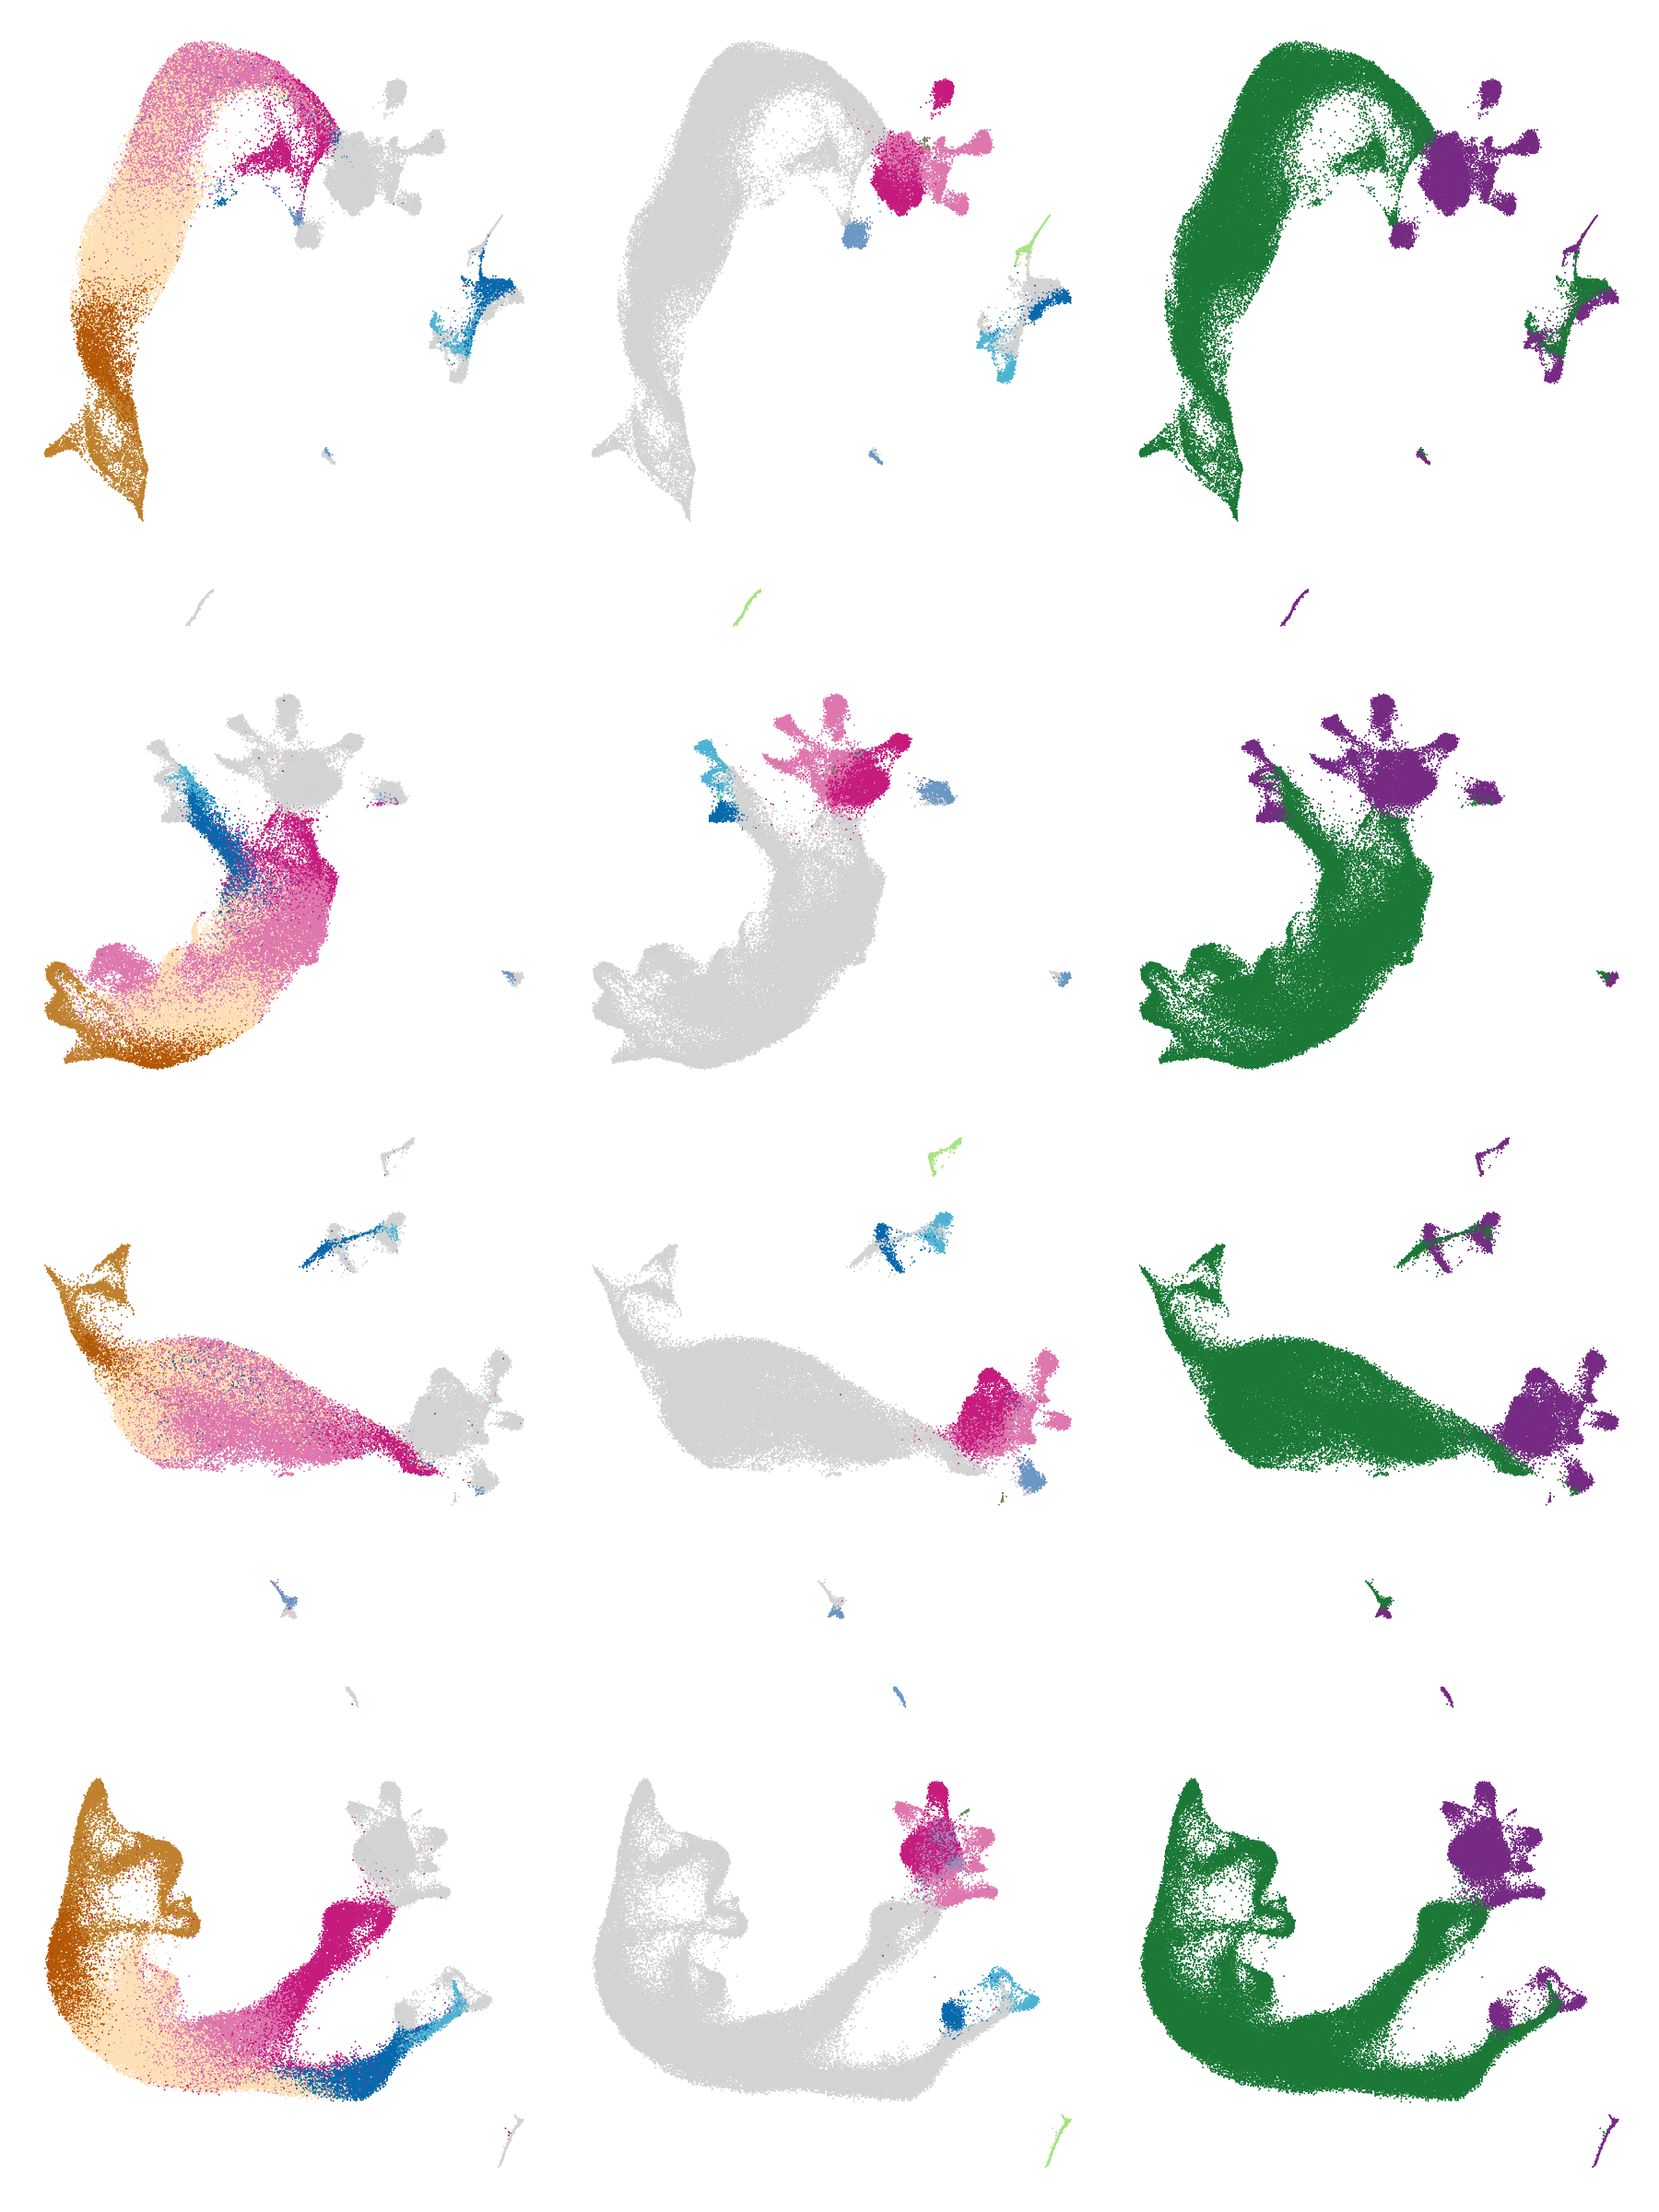

In [3]:
## Colors
fetal_cols <- setNames(c("#bf812d", "#b35806", "#fee0b6", 
                "#c51b7d", "#de77ae", 
                         "#0868ac", "#6a98c4", "#6a98c4", "#4eb3d3"),
                c("IPC EOMES NEUROG1", "IPC EOMES NHLH1", "ExN nascent",
                "ExN up ACTN2", "ExN up ADRA2A", 
                  "ExN deep SYT6","ExN deep OPRK1 SULF1","ExN deep OPRK1 NR4A2", "ExN deep NR4A2 GRID2"))
adult_cols <- setNames(c("#c51b7d", "#de77ae", "#6a8f54", "#a3e67c", "#0868ac", "#6a98c4", "#6a98c4", "#4eb3d3"), 
                c("L2_3_IT", "L3_5_IT", "L5_PT", "L5_6_NP", "L6_CT", "L6_IT_1", "L6_IT_2", "L6b"))
col_list <- list(fetalcls = fetal_cols, 
            adultcls = adult_cols, 
            stage = setNames(c("#1b7837", "#762a83"), c("fetal", "adult")))

p_regs <- lapply(all_regs, function(reg){
    pdata <- pdata_list[[reg]]
    
    ## permutate the dot order
    set.seed(42)
    pdata <- pdata[sample(1:nrow(pdata)), ]


    plist <- lapply(c("fetalcls", "adultcls", "stage"), function(tp) {
        p <- ggplot(pdata, aes_string(x = "UMAP_1", y = "UMAP_2", color = tp)) +
                    ggrastr::rasterise(geom_point(size = 0.1, shape = 16), dpi = 300, scale = 1) +
                    theme_classic() + 
                    scale_color_manual(values = col_list[[tp]], na.value = "lightgrey") + 
                    theme(legend.position = "none",
                            line = element_blank(),axis.title.x = element_blank(),axis.title.y = element_blank(),
                            axis.text.x=element_blank(),axis.text.y=element_blank(), 
                            plot.title = element_blank())
        return(p)
        })  
    return(plist)
}) %>%
    do.call(c, .)


p_cbn <- patchwork::wrap_plots(p_regs, nrow = length(all_regs), ncol = 3)
options(repr.plot.width=15, repr.plot.height=20)

p_cbn

In [4]:
pdf(paste0("./report/", "AdultFetal_ExN_integration_identities.pdf"), width = 15, height = 20)
print(p_cbn)
dev.off()

png 
  2

In [5]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.0 dplyr_1.0.7   Seurat_3.1.5 

loaded via a namespace (and not attached):
 [1] nlme_3.1-147        tsne_0.1-3          RcppAnnoy_0.0.16   
 [4] RColorBrewer_1.1-2  httr_1.4.1 